In [4]:
#-*- encoding: iso-8859-15 -*-
import numpy as np
from easydict import EasyDict as edict

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from matplotlib import pyplot as plt

import heapq

# Import other python files


#### Configuration / parameters to set

In [5]:
def set_config(config_path = "config.txt", args = dict()):
    with open(config_path) as source:
        for line in source:
            line = line.strip()
            argLong, valueLong = line.split('=')
            arg = argLong.strip()
            value = valueLong.strip()
            if value == 'True':
                value = True
            elif value == 'False':
                value = False
            elif '.' in value:
                value = float(value)
            else:
                value = int(value)
            args[arg] = value
    return edict(args)

In [6]:
config_path = 'config.txt'
args = {}
args = set_config(config_path, args)
print(args)
#args.batch_size = 9

{'seq_len': 40, 'offset': 1, 'cuda': False, 'batch_size': 16, 'num_layers': 1, 'hidden_size': 128, 'lr': 0.1, 'clip': 1}


### Data Processing functions and classes

In [24]:
def prepare_text(textsource):
    text = ''
    with open(textsource, encoding="utf8") as txtsource:
        for line in txtsource:
            line = line.strip().lower()
            line = line.replace(',', '').replace('.', '')
            line = line.replace('»', '').replace('«', '')
            line = line.replace('"', '')
            line = line.replace(u'\ufeff', '')
            text += ' ' + line
    text = text[:32040] #### nachher wieder rauslöschen!!!
    return text
# Chevrons müssen noch weg

In [13]:
def prepare_data(text, seq_len, offset):
    # Get all the unique characters appearing in the text 
    chars = sorted(list(set(text)))
    char_idx = dict((c, i) for i, c in enumerate(chars))
    print('char_indices_map: ' + str(char_idx))
    print('len(char_indices_map): ' + str(len(char_idx)))
    idx_char = dict((i, c) for i, c in enumerate(chars)) #### das brauchen wir später!!!
    no_classes = len(chars) # the nr. of unique characters corresponds to the nr. of classes
    
    # Define training samples by splitting the text
    sentences = []
    next_chars = []
    for i in range(0, len(text) - seq_len, offset):
        sentences.append(text[i: i + seq_len])
        next_chars.append(text[i + seq_len])

    #print('sentences', sentences)    
    #print('next_chars', next_chars)
    print('nr training samples', len(sentences))
    
    # Generate features and labels using one-hot encoding
    X = np.zeros((len(sentences), seq_len, len(chars)), dtype='f')
    y = np.zeros((len(sentences)))
    gt = np.zeros((len(sentences), len(chars)), dtype = 'f')
    
    for i, sentence in enumerate(sentences):
        for j, char in enumerate(sentence):
            X[i, j, char_idx[char]] = 1
        y[i] = char_idx[next_chars[i]]
        gt[i, char_idx[next_chars[i]]] = 1
        
    #print('next_chars: ' + str(next_chars[0]))
    #print('out: ' + str(X[0, :, :]))
    #print('target: ' + str(y[0]))
        
    return X, y, gt, char_idx, idx_char, no_classes

In [13]:
class TextDataset(Dataset):
    ''' A text dataset class which implements the abstract class torch.utils.data.Dataset. '''
    def __init__(self, text, seq_len, offset):
        self.data, self.target, self.gt, self.char_idx, self.idx_char, self.no_classes = prepare_data(text, seq_len, offset)
        
    def __getitem__(self, index):
        ''' Get the data for one training sample (by index) '''
        return self.data[index,:,:], self.target[index] 
    
    def __len__(self):
        ''' Get the number of training samples '''
        return self.data.shape[0]

### LSTM functions and classes

In [15]:
class LSTM_RNN(nn.Module):
    
    def __init__(self, no_classes):
        super(LSTM_RNN, self).__init__()
        
        self.lstm = nn.LSTM(input_size = no_classes, hidden_size = args.hidden_size, num_layers = args.num_layers)
        self.linear = nn.Linear(in_features = args.hidden_size, out_features = no_classes)
        self.softmax = nn.Softmax(dim=1)
        
        nn.init.normal( self.linear.weight, 0, 0.075)
        nn.init.normal(self.linear.bias, 0, 0.075)
        nn.init.xavier_normal(self.lstm.weight_hh_l0)
        nn.init.xavier_normal(self.lstm.weight_ih_l0)
        #nn.init.constant(self.lstm.bias, 0.0)

        
        # LSTM needs hidden variable which is initialized in self.init_hidden(self)
        self.hidden = self.init_hidden()
        
        # for m in self.modules():
        #     if isinstance(m, nn.Linear):
        #         m.weight.data.normal_(0, 0.075*0.075)
        #         m.bias.data.normal_(0, 0.075*0.075)
                
    
    def init_hidden(self):
        h0 = Variable(torch.zeros(args.num_layers, args.batch_size, args.hidden_size))
        c0 = Variable(torch.zeros(args.num_layers, args.batch_size, args.hidden_size))
        return (h0,c0)#Variable(torch.zeros((args.num_layers, args.batch_size, args.hidden_size)))
    
    def forward(self, x, hidden):
        #x = x.type(torch.DoubleTensor)
        #print(x)
        lstm_out, hidden = self.lstm(x, hidden) # (h0, c0 are set to default values)
        #print(lstm_out)
        #print("LSTM_OUT:")
        #print(lstm_out)
        #lstm_out = lstm_out.view(-1, lstm_out.size(2))
        #print("----------------")
        #print(lstm_out)
        linear_out = self.linear(lstm_out[-1])
        #print("Linear_OUT:")
        #print(linear_out)
        #res = self.softmax(linear_out) # use only the output of the last layer of lstm
        return linear_out, hidden

In [16]:
# Training loop (one epoch)
def train(model, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss() # use the cross-entropy loss
    total_loss = 0.0 # compute total loss over one epoch

    for batch_idx, (data, target) in enumerate(train_loader):
        #print(data)
        data = data.transpose(0, 1) #swap seq_len and batch:size
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        hidden = model.init_hidden()
        optimizer.zero_grad()
        #print("data:")
        #print(data[0, :, :])
        output, hidden = model(data, hidden)
        #print("output:")
        #print(output[0])
        #print("target:")
        #print(target)
        #print("output:")
        #print(output)
        loss = criterion(output, target.type(torch.LongTensor)) # check how far away the output is from the original data
        #print("loss:")
        #print(loss)
        loss.backward(retain_graph=True)
        
        #torch.nn.utils.clip_grad_norm(model.parameters(), args.clip)
        optimizer.step()

        total_loss += loss.data[0]
        #print(total_loss)


    relative_loss = total_loss/float(len(train_loader))
    print('Mean loss over epoch %s: %s' %(epoch, relative_loss))#loss.data[0]))
    return relative_loss # return the relative loss for later analysis
            

In [17]:
# Evaluation loop (one epoch)
def evaluate(model, epoch):
    model.eval()
    criterion = nn.CrossEntropyLoss() # use the cross-entropy loss
    total_loss = 0.0 # compute total loss over one epoch

    for batch_idx, (data, target) in enumerate(train_loader):
        #print(data)
        data = data.transpose(0, 1)
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        hidden = model.init_hidden()
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        loss = criterion(output, target.type(torch.LongTensor)) # check how far away the output is from the original data

        total_loss += loss.data[0]


    model.train()
    relative_loss = total_loss/float(len(train_loader))
    print('Mean loss over epoch %s: %s' %(epoch, relative_loss))#loss.data[0]))
    return relative_loss # return the relative loss for later analysis
            

In [18]:
# Prediction loop for ONE testdata tensor
def rnn_predict(model, testdata):
    ''' Note: testdata have to be submitted as a tensor'''
    testdata = torch.from_numpy(testdata)
    #print("testdata:")
    #print(testdata)
    model.eval()
    testdata = testdata.view(testdata.size(0), -1)
    if args.cuda:
        testdata = testdata.cuda()
    testdata = testdata.type(torch.FloatTensor)
    testdata = Variable(testdata)
    hidden = model.init_hidden()
    prediction = model(testdata, hidden)
    return prediction

### Other functions

In [19]:
''' Function that returns the largest factor of number that isn't the number itself '''
def lfactor(num):
    for i in range(num - 1, 0, -1): # go backwards from num - 1 to 1
        if num % i == 0:            # if a number divides evenly
            return i                # it's the largest factor

### Marvins test functions

In [20]:
# die funktion brauchen wir vllt gar nicht, je nachdem ob wir den test loader verwenden oder wie wir das auch immer machen
def prepare_input(text):
    X = np.zeros((args.seq_len, no_classes))  # array with one entry which have 20 lines, each 11 entrys
    offset = 0
    if len(text)<args.seq_len:
        offset = args.seq_len-len(text)
    for t, char in enumerate(text):          
        X[t+offset, char_idx[char]] = 1.
    return X

def sample(preds, top_n=1):
    #print("test")
    preds = preds[-1].data.numpy()
    #print(preds)
    #print(preds.shape)
    #preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(len(preds), zip(preds, itertools.count()))


def predict_completion(model, text, topn=1):
    original_text = text
    processed = text
 
    #print(len(processed))
    max_iterations = 10
    i = 0
    completion = ''
    next_char = '' # init
    while next_char != ' ' and i < max_iterations:
        i += 1
        x = prepare_input(text)
        preds = rnn_predict(model, x)
        next_chars = sample(preds[0], top_n=topn)
        #print('id, char: ' + str(next_chars[0][1]) + ', ' + str(idx_char[next_chars[0][1]]))
        text = text[1:] + idx_char[next_chars[0][1]]
        completion += idx_char[next_chars[0][1]]
        next_char = idx_char[next_chars[0][1]]

    return completion


def predict_completions(model, text, n=3):
    x = prepare_input(text)
    preds = model.rnn_predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [idx_char[idx] + predict_completion(text[1:] + idx_char[idx]) for idx in next_indices]

### Main code

In [25]:
config_path = 'config.txt'
args = {}
args = set_config(config_path, args)
print(args)

# Generate train and test loader from our data
train_text = prepare_text('./Brown_Leseprobe.txt')
train_set = TextDataset(train_text, args.seq_len, args.offset)
#args.batch_size = lfactor(len(train_set))
train_loader = DataLoader(train_set, batch_size = args.batch_size, shuffle=False)
gt = train_set.gt

def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])

# for i, val in enumerate(train_loader):
#     print(val)
#     if i==1:
#         break

test_text = prepare_text('./Brown_Leseprobe_test.txt')
test_set = TextDataset(test_text, args.seq_len, args.offset)
test_loader = DataLoader(test_set, batch_size = args.batch_size, shuffle=False)

# set further parameters
char_idx = train_set.char_idx
idx_char = train_set.idx_char
no_classes = train_set.no_classes
input_shape = (args.seq_len, no_classes) # seq_len * nr. of unique characters 

# get len of data to determine the possible batch_size
print(args.batch_size)


{'seq_len': 40, 'offset': 1, 'cuda': False, 'batch_size': 16, 'num_layers': 1, 'hidden_size': 128, 'lr': 0.1, 'clip': 1}
char_indices_map: {' ': 0, '!': 1, '*': 2, '-': 3, '1': 4, '3': 5, '7': 6, '8': 7, '9': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'ß': 38, 'ä': 39, 'ó': 40, 'ö': 41, 'ü': 42, 'ā': 43, '–': 44, '‘': 45, '’': 46, '…': 47, '‹': 48, '›': 49}
len(char_indices_map): 50
nr training samples 32000


char_indices_map: {' ': 0, '!': 1, '*': 2, '-': 3, '1': 4, '3': 5, '7': 6, '8': 7, '9': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'ß': 38, 'ä': 39, 'ó': 40, 'ö': 41, 'ü': 42, 'ā': 43, '–': 44, '‘': 45, '’': 46, '…': 47, '‹': 48, '›': 49}
len(char_indices_map): 50
nr training samples 32000


16


In [26]:
# Generate model
print(input_shape)
rnn = LSTM_RNN(no_classes)
if args.cuda:
    rnn.cuda()
print(rnn)

(40, 50)
LSTM_RNN(
  (lstm): LSTM(50, 128)
  (linear): Linear(in_features=128, out_features=50)
  (softmax): Softmax()
)


In [27]:
# Initialize the optimization algorithm
optimizer = optim.Adam(rnn.parameters())

In [66]:

# Run training and store history
#history = dict()
#history['loss_train'] = []
#history['loss_test'] = []

# wie wir die accuracy machen, weiß ich noch nicht...
#history['acc_train'] = []
#history['acc_test'] = []
print(args.batch_size)
for epoch in range(10):
    loss_train = train(rnn, epoch)
    loss_test = evaluate(rnn, epoch)
    history['loss_train'].append(loss_train)
    history['loss_test'].append(loss_test)
    

16


Mean loss over epoch 0: 0.914361091222614


Mean loss over epoch 0: 1.1703812665045261


Mean loss over epoch 1: 0.8921527316980064


Mean loss over epoch 1: 1.1976458085924386


Mean loss over epoch 2: 0.8814950854219497


Mean loss over epoch 2: 1.150560363523662


C:\WinPython\miniconda2\lib\site-packages\torch\serialization.py:158: UserWarning: Couldn't retrieve source code for container of type LSTM_RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


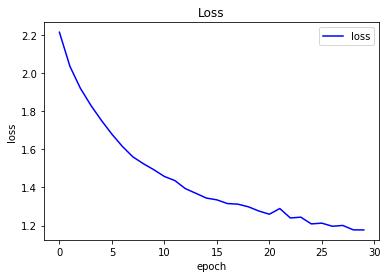

In [44]:
torch.save(rnn, 'rnn_bsize16-l0.9.pt')

def plotLineData(header, yLabel, firstData, firstLabel, firstColor='b', xLabel='epoch'):
    plt.plot(firstData, color=firstColor)
    plt.title(header)
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.legend([firstLabel], loc='upper right')
    plt.savefig("loss_test.png")
    plt.show()
plotLineData("Loss", "loss", history['loss_test'], "loss")
# Try a prediction

#testdata = Variable(torch.from_numpy(test_set.data[0])) # get first element from the test set
#truth = test_set.target[0]
#print(testdata,truth)

#prediction = rnn(testdata)
## dann muss man hier noch auf die sizes achten, ach verdammt
#prepare_input("This is an example of input for our LSTM".lower(), train_set.data, char_idx)
#print(predict_completions(seq, 5))

In [46]:

testcases = ["rfolge kleiner Eruptionen in heftige Bew", "während die historische zahnradbahn sic", 
             "hrend die historische zahnradbahn sich m", "nd die historische zahnradbahn sich mühs", 
             "e historische zahnradbahn sich mühsam ih", "torische zahnradbahn sich mühsam ihren w", 
             "che zahnradbahn sich mühsam ihren weg de", "hnradbahn sich mühsam ihren weg den schw", 
             "n sich mühsam ihren weg den schwindelerr", "am ihren weg den schwindelerregend steil",
             "hwindelerregend steilen hang hinaufkrall"]
for case in testcases:
    print(predict_completion(rnn, case.lower()))

egung 
h 


uss 


um 


ren 


eg 
r 


inflichen 


egenun 
e 


ten 


In [29]:

testcases = ["mühsam ihren Weg den schwindel", "hen Außenhaut der reptilienart", 
             "schien das weitläufige Kloster", " flanke einer senkrecht aufrag", 
             "irsch auf die gezackten bergsp", "ebaut in die flanke einer senk", 
             "in den bergen und andere unbil", "hner vor der modernen welt abz", 
             "egend steilen Hang hinaufkrall", "uf magische Weise von der fels",
             "den des Wetters und der Geschi"]
for case in testcases:
    print(predict_completion(rnn, case.lower()))

ert 


ang 


gage 


ende 


itiert 


recht 


len 


ustonische


ichen 


saut 


chte 


In [30]:
testcases = ["Während die historis", "ihren Weg den schwin", 
             "iner senkrecht aufra", "re Unbilden des Wett", 
             "eilen Hang hinaufkra", "die gezackten Bergsp", 
             "ichen Bestimmung abz", "er modernen Welt abz"]
for case in testcases:
    print(predict_completion(rnn, case.lower()))

chen 


kelt 


genden 


er 


lligen 


ente 


ukonne 


uschoften 


In [65]:
testcases = ["historis", "schw", "Garte", "senkrech", "Wett",
             "hinau", "die gezackte", 
             "abz", "er modernen Welt abz"]
for case in testcases:
    print(predict_completion(rnn, case.lower()))

chen 


ielt 


n 


te 


en 
f 


n 


ig 


uschoften 


In [37]:
print(train_set.no_classes)
print(char_idx)
print(args.batch_size)


50
{' ': 0, '!': 1, '*': 2, '-': 3, '1': 4, '3': 5, '7': 6, '8': 7, '9': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'ß': 38, 'ä': 39, 'ó': 40, 'ö': 41, 'ü': 42, 'ā': 43, '–': 44, '‘': 45, '’': 46, '…': 47, '‹': 48, '›': 49}
8
